# ** Tweets Toxicity using NLP**
This project is about training an RNN model using LSTM technique to predict if a tweet is really linked to a disaster or not.

# Importing Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn import model_selection

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Uploading The dataset

In [4]:
train_file_path = "./train.csv"
train_data = pd.read_csv(train_file_path)
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_file_path = "./test.csv"
test_data = pd.read_csv(test_file_path)
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Understanding data distribution

**Checking for missing entries**

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
train_data['id'].count()

7613

In [8]:
test_data['id'].count()

3263

I decided to do my analysis on the whole dataset not just the train dataset.
So, I concatenated the train and test datasets to one dataset.

In [9]:
train_data_without_target = train_data.drop("target", axis=1, inplace=False)
dataset=pd.concat([train_data_without_target ,test_data],axis=0)
dataset.head()

,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


In [10]:
train_data['target'].isnull().sum()

0

Calculating the percentage of missing entries in each class.

In [11]:
percentage_missing=(dataset.isnull().sum()/dataset['id'].count())*100
percentage_missing

id           0.000000
keyword      0.799926
location    33.449798
text         0.000000
dtype: float64

Calculating the count of unique entries in each class.

In [12]:
keyword_value_count = dataset['keyword'].value_counts()
location_value_count = dataset['location'].value_counts()
target_value_count = train_data['target'].value_counts()

print('keyword_value_count:\n',keyword_value_count)
print('location_value_count:\n',location_value_count)
print('target_value_count:\n',target_value_count)

keyword_value_count:
 ablaze                   50
lava                     50
loud%20bang              50
mass%20murder            50
massacre                 50
                         ..
forest%20fire            24
threat                   16
radiation%20emergency    14
inundation               14
epicentre                13
Name: keyword, Length: 221, dtype: int64
location_value_count:
 USA                       141
New York                  109
United States              65
London                     58
Canada                     42
                         ... 
Brooklyn                    1
St.Cloud, MN                1
on a catwalk somewhere      1
  å_                        1
Brussels, Belgium           1
Name: location, Length: 4521, dtype: int64
target_value_count:
 0    4342
1    3271
Name: target, dtype: int64


Getting the top 15 locations and keywords.

In [13]:
top_15_locations = dataset['location'].value_counts()[0:15]
print(top_15_locations)

USA                141
New York           109
United States       65
London              58
Canada              42
Nigeria             40
Worldwide           35
India               35
Los Angeles, CA     34
UK                  33
Kenya               32
Washington, DC      31
Mumbai              28
United Kingdom      26
California          25
Name: location, dtype: int64


In [14]:
top_15_keywords = dataset['keyword'].value_counts()[0:15]
print(top_15_keywords)

ablaze                50
lava                  50
loud%20bang           50
mass%20murder         50
massacre              50
mayhem                50
meltdown              50
military              50
mudslide              50
natural%20disaster    50
nuclear%20disaster    50
nuclear%20reactor     50
obliterate            50
obliterated           50
obliteration          50
Name: keyword, dtype: int64


# Data Preprocessing

**Cleaning Text **

In [23]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean_text(texts):
 
    texts_no_url = re.sub(r"http\S+", "", texts)    # removing URL  
    text_no_num = re.sub(r'\d+', '', texts_no_url)   # removing numbers  
    word_tokens = word_tokenize(text_no_num)   # tokenize each text
  
    clean_text = []
    for word in word_tokens:
        clean_text.append("".join([e for e in word if e.isalnum()]))  
    
    text_with_no_stop_word = [w.lower() for w in clean_text if not w in stop_words]  # removing stop words and lower
    stemmed_text = [stemmer.stem(w) for w in text_with_no_stop_word]  # stemming
  
    return " ".join(" ".join(stemmed_text).split())


train_data['clean_text'] = train_data['text'].apply(lambda x: clean_text(x) )
train_data['keyword'] = train_data['keyword'].fillna("none")
train_data['clean_keyword'] = train_data['keyword'].apply(lambda x: clean_text(x) )

train_data['keyword_text'] = train_data['clean_keyword'] + " " + train_data["clean_text"]

**Splitting data for training and testing** 

Note: I did not use the uploaded test file bvecause it does not contain a target column. So, I splitted the uploaded train file into train and test data.

In [25]:
X_train, X_test,y_train, y_test = model_selection.train_test_split(train_data['keyword_text'],
                                                                   train_data['target'],
                                                                   test_size=0.3,
                                                                   random_state=0, 
                                                                   shuffle=True)

y_train_LSTM = y_train.values.reshape(-1,1)
y_test_LSTM = y_test.values.reshape(-1,1)

In [26]:
# Tokenize train data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocabulary Size: ", vocab_size)

Vocabulary Size:  11271


In [27]:
# Pad train and test 
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

print("Training X shape: ", X_train.shape)
print("Testing X shape: ", X_test.shape)

Training X shape:  (5329, 100)
Testing X shape:  (2284, 100)


In [28]:
# embedding
path_to_glove_file = './glove.6B.300d.txt' 

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 79008 word vectors.


In [30]:
# Define embedding layer in Keras
embedding_matrix = np.zeros((vocab_size,  300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            300,
                                            weights=[embedding_matrix],
                                            input_length=100,
                                            trainable=False)

# Model Architecture

In [31]:
# Define model architecture
sequence_input = Input(shape=(100, ), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedding_sequences)
x = Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          3381300   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           192128    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [32]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model

In [33]:
history = model.fit(X_train,
                    y_train,
                    batch_size=1024,
                    epochs=20, 
                    validation_data=(X_test, y_test))

Epoch 1/20
6/6 [==============================] - 62s 9s/step - loss: 0.6600 - accuracy: 0.5982 - val_loss: 0.5453 - val_accuracy: 0.7430
Epoch 2/20
6/6 [==============================] - 48s 8s/step - loss: 0.5437 - accuracy: 0.7504 - val_loss: 0.5375 - val_accuracy: 0.7439
Epoch 3/20
6/6 [==============================] - 49s 8s/step - loss: 0.5054 - accuracy: 0.7634 - val_loss: 0.5080 - val_accuracy: 0.7710
Epoch 4/20
6/6 [==============================] - 48s 8s/step - loss: 0.4716 - accuracy: 0.7861 - val_loss: 0.5026 - val_accuracy: 0.7798
Epoch 5/20
6/6 [==============================] - 49s 8s/step - loss: 0.4560 - accuracy: 0.7968 - val_loss: 0.4887 - val_accuracy: 0.7828
Epoch 6/20
6/6 [==============================] - 48s 8s/step - loss: 0.4293 - accuracy: 0.8133 - val_loss: 0.5200 - val_accuracy: 0.7793
Epoch 7/20
6/6 [==============================] - 48s 8s/step - loss: 0.4110 - accuracy: 0.8221 - val_loss: 0.5233 - val_accuracy: 0.7658
Epoch 8/20
6/6 [==================

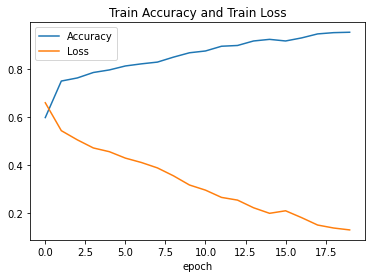

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Train Accuracy and Train Loss')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

In [37]:
# Evaluate the model
predicted = model.predict(X_test, verbose=1, batch_size=10000)

y_predicted = [1 if each > 0.5 else 0 for each in predicted]

score, test_accuracy = model.evaluate(X_test, y_test, batch_size=10000)

print("Test Accuracy: ", test_accuracy)
print(metrics.classification_report(list(y_test), y_predicted))

1/1 [==============================] - 5s 5s/step - loss: 0.8236 - accuracy: 0.7640
Test Accuracy:  0.764010488986969
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      1338
           1       0.71      0.72      0.72       946

    accuracy                           0.76      2284
   macro avg       0.76      0.76      0.76      2284
weighted avg       0.76      0.76      0.76      2284



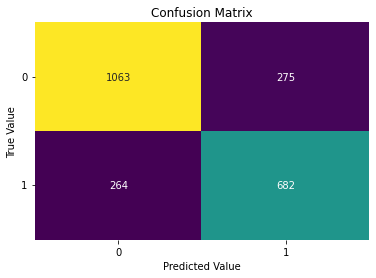

In [41]:
# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='viridis', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)
plt.show()